In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

print("Feature names:", data.feature_names[:5], "...")
print("Target names:", data.target_names)
print("Dataset shape:", X.shape)


Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness'] ...
Target names: ['malignant' 'benign']
Dataset shape: (569, 30)


In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [4]:
dataset = TensorDataset(X_tensor, y_tensor)

# 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [5]:
class BreastCancerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(30, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)

model = BreastCancerModel()


In [6]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [10/50]  Loss: 0.2348
Epoch [20/50]  Loss: 0.0861
Epoch [30/50]  Loss: 0.0581
Epoch [40/50]  Loss: 0.0421
Epoch [50/50]  Loss: 0.0330


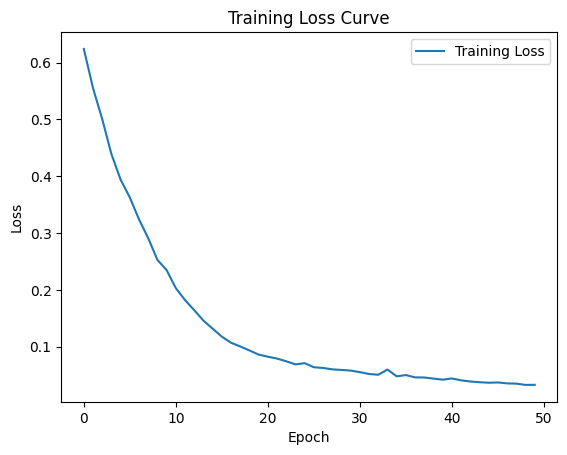

In [8]:
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


In [9]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        preds = (preds >= 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Accuracy
acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=data.target_names))



✅ Test Accuracy: 97.37%

Classification Report:
               precision    recall  f1-score   support

   malignant       1.00      0.93      0.97        45
      benign       0.96      1.00      0.98        69

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



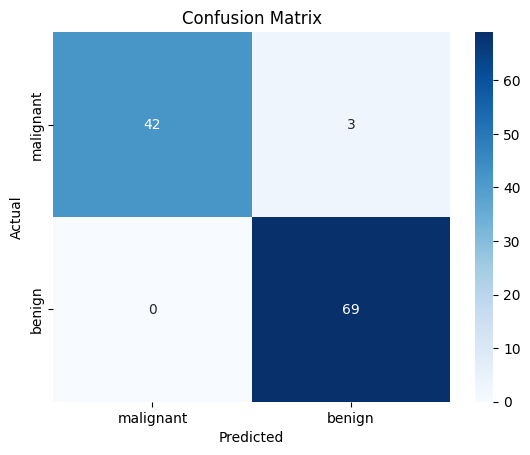

In [10]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
torch.save(model.state_dict(), "breast_cancer_model.pth")